In [ ]:
%load_ext autoreload
%autoreload 2

# 🏆 Sports League Optimization Analysis (Rebuilt with Utils) 🏆

This script orchestrates the comparison of various optimization algorithms
for the sports league assignment problem. It uses refactored algorithm modules
and a separate `experiment_utils.py` for helper functions.
It parallelizes the independent *runs* of each algorithm configuration.

## 0. Imports and Global Setup ⚙️

In [ ]:
# Standard library imports
import time
import random
import multiprocessing as mp
from copy import deepcopy 
import pickle
import logging
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # For progress bars

# Custom module imports
from solution import (
    LeagueSolution,
    LeagueHillClimbingSolution,
    LeagueSASolution,
)

from evolution import (
    hill_climbing,
    simulated_annealing,
    hill_climbing_random_restart 
)
from operators import (
    genetic_algorithm,
    genetic_algorithm_island_model, 
    selection_tournament_variable_k,
    selection_ranking,
    selection_boltzmann, 
    crossover_one_point_prefer_valid,
    crossover_uniform_prefer_valid,
    crossover_two_point_prefer_valid, 
    mutate_swap,
    mutate_swap_constrained,
    mutate_team_shift,
    mutate_targeted_player_exchange,
    mutate_shuffle_within_team_constrained,
    hc_wrapper_for_ga
    )


from experiment_utils import (
    safe_exp, FitnessCounter, 
    extract_solution_data_for_storage, recreate_solution_from_data,
    safe_exp,
    # plotting functions
    plot_summary_statistics_bars,
    plot_metric_distributions_boxplots,
    plot_convergence_curves,
    rank_algorithms_custom,
    display_single_best_solution_details
)

import solution as solution_module_ref # Import the solution module to pass to recreate_solution_from_data

# --- Logging Configuration ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - [%(processName)s] - %(module)s.%(funcName)s:%(lineno)d - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[logging.StreamHandler()] # Optional: add FileHandler
)
logger = logging.getLogger(__name__)

# --- Plotting Style Configuration ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    logger.warning("Seaborn style 'seaborn-v0_8-whitegrid' not found. Using default.")
    plt.style.use('default')
sns.set_palette("Spectral")
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['figure.dpi'] = 90
plt.rcParams['savefig.dpi'] = 200

logger.info("Script setup complete: Modules imported, logging and plotting configured. 🚀")

2025-05-26 02:02:53 - INFO - [MainProcess] - 4204748363.<module>:81 - Script setup complete: Modules imported, logging and plotting configured. 🚀


## 1. Problem Definition & Data Loading ⚽️

### 1.1 Core Problem Parameters

In [ ]:
NUM_TEAMS = 5
TEAM_SIZE = 7
MAX_BUDGET = 750.0
PLAYER_DATA_CSV_FILEPATH = "players.csv" # Ensure this file is accessible

# Define Position Requirements based on TEAM_SIZE
if TEAM_SIZE == 7:
    PROBLEM_POSITION_REQUIREMENTS = {"GK": 1, "DEF": 2, "MID": 2, "FWD": 2}
# Add other elif blocks for different TEAM_SIZE if needed
# elif TEAM_SIZE == 11:
#     PROBLEM_POSITION_REQUIREMENTS = {"GK": 1, "DEF": 4, "MID": 4, "FWD": 2}
else:
    raise ValueError(f"No predefined position requirements for TEAM_SIZE = {TEAM_SIZE}.")

if sum(PROBLEM_POSITION_REQUIREMENTS.values()) != TEAM_SIZE:
    logger.critical("Config Error: Position requirements sum mismatch team size. Exiting.")
    exit()

problem_definition_global = {
    'num_teams': NUM_TEAMS,
    'team_size': TEAM_SIZE,
    'max_budget': MAX_BUDGET,
    'position_requirements': PROBLEM_POSITION_REQUIREMENTS,
}
logger.info(f"Global Problem Definition Set: {problem_definition_global}")

2025-05-26 02:02:54 - INFO - [MainProcess] - 321466763.<module>:25 - Global Problem Definition Set: {'num_teams': 5, 'team_size': 7, 'max_budget': 750.0, 'position_requirements': {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2}}


### 1.2 Player Data Loading

In [ ]:
def load_and_preprocess_player_data(csv_filepath: str) -> list:
    logger.info(f"Loading player data from: '{csv_filepath}'...")
    try:
        players_df = pd.read_csv(csv_filepath, sep=";")
    except FileNotFoundError:
        logger.critical(f"FATAL: Player data '{csv_filepath}' not found. Exiting.")
        raise
    except Exception as e:
        logger.critical(f"FATAL: Error reading '{csv_filepath}': {e}")
        raise

    if "Salary (€M)" in players_df.columns and "Salary" not in players_df.columns:
        players_df["Salary"] = players_df["Salary (€M)"]
    elif "Salary" not in players_df.columns: # Ensure Salary column exists
        logger.warning("Salary column not found. Defaulting salaries to 0.0.")
        players_df["Salary"] = 0.0
    
    players_df["Salary"] = pd.to_numeric(players_df["Salary"], errors='coerce').fillna(0.0)

    required_cols = ["Name", "Position", "Skill", "Salary"] # Adjust if PlayerID is used by name
    missing = [col for col in required_cols if col not in players_df.columns]
    if missing:
        logger.critical(f"FATAL: Missing required columns in player data: {missing}. Exiting.")
        raise ValueError(f"Missing columns: {missing}")

    loaded_data = players_df.to_dict(orient="records")
    logger.info(f"Loaded {len(loaded_data)} players from {csv_filepath}.")
    return loaded_data

players_data = load_and_preprocess_player_data(PLAYER_DATA_CSV_FILEPATH) #

TOTAL_PLAYERS_NEEDED = problem_definition_global['num_teams'] * problem_definition_global['team_size'] #

if len(players_data) != TOTAL_PLAYERS_NEEDED:
    logger.critical(f"CRITICAL: The number of players in '{PLAYER_DATA_CSV_FILEPATH}' ({len(players_data)}) "
                    f"does not match the required number for the league ({TOTAL_PLAYERS_NEEDED}). "
                    f"The script requires exactly {TOTAL_PLAYERS_NEEDED} players as per the problem definition. Please adjust the player data or configuration. Exiting.")
    exit()
else:
    logger.info(f"Player data has exactly {len(players_data)} players, matching the {TOTAL_PLAYERS_NEEDED} required. Proceeding.") #

2025-05-26 02:02:54 - INFO - [MainProcess] - 1835640795.load_and_preprocess_player_data:2 - Loading player data from: 'players.csv'...
2025-05-26 02:02:54 - INFO - [MainProcess] - 1835640795.load_and_preprocess_player_data:27 - Loaded 35 players from players.csv.
2025-05-26 02:02:54 - INFO - [MainProcess] - 1835640795.<module>:40 - Player data has exactly 35 players, matching the 35 required. Proceeding.


## 2. Experiment Configuration & Utilities 🛠️

### 2.1 Algorithm Configurations

In [ ]:

all_configs = {
    # --- Hill Climbing Based (use 'params') ---
    "HillClimbing_Std": {
        'algorithm_func': hill_climbing,
        'solution_class': LeagueHillClimbingSolution,
        'params': {
            "max_iterations": 500,
            "max_no_improvement": 100,
            "verbose": False
        }
    },
    "HillClimbing_Intensive": {
        'algorithm_func': hill_climbing,
        'solution_class': LeagueHillClimbingSolution,
        'params': {
            "max_iterations": 1000,
            "max_no_improvement": 200,
            "verbose": False
        }
    },
    "HillClimbing_RandomRestart_Test": {
        'algorithm_func': hill_climbing_random_restart,
        'solution_class': LeagueHillClimbingSolution, # For FitnessCounter & default for HCRR's internal solution_class_for_hc
        'params': {
            # 'solution_class_for_hc' will be injected by run_single_experiment_instance if not here,
            # but it's better to be explicit if HCRR function expects it directly.
            # The HCRR function signature asks for 'solution_class_for_hc' directly.
            # run_single_experiment_instance was modified to inject this from top-level 'solution_class'.
            'num_restarts': 10,
            'max_iterations_per_hc': 200,
            'max_no_improvement_per_hc': 50,
            'verbose': False,
            'hc_specific_kwargs': {} # Additional kwargs for the inner hill_climbing if its signature supports them via **kwargs
        }
    },

    # --- Simulated Annealing Based (use 'params') ---
    "SimulatedAnnealing_Std": {
        'algorithm_func': simulated_annealing,
        'solution_class': LeagueSASolution,
        'params': {
            "initial_temperature": 200.0,
            "cooling_rate": 0.95,
            "min_temperature": 1e-5,
            "iterations_per_temp": 20,
            "verbose": False
            # 'safe_exp_func': safe_exp is added by run_single_experiment_instance
        }
    },
    "SimulatedAnnealing_Enhanced": {
        'algorithm_func': simulated_annealing,
        'solution_class': LeagueSASolution,
        'params': {
            "initial_temperature": 300.0,
            "cooling_rate": 0.97,
            "min_temperature": 1e-6,
            "iterations_per_temp": 30,
            "verbose": False
        }
    },

    # --- Genetic Algorithm Based (use 'ga_specific_params') ---
    "GA_Tournament_OnePoint": {
        'algorithm_func': genetic_algorithm,
        'solution_class': LeagueSolution, 
        'ga_specific_params': {
            "population_size": 100,
            "max_generations": 50,
            "elitism_size": 2,
            "selection_operator": selection_tournament_variable_k,
            "selection_params": {"k_percentage": 0.03}, # k=3 for pop_size=100
            "crossover_operator": crossover_one_point_prefer_valid,
            "crossover_rate": 0.8, # GA's internal logic should use this
            "mutation_operator": mutate_targeted_player_exchange,
            "mutation_rate": 0.1, # GA's internal logic should use this (prob_apply_mutation)
            "verbose": False,
            # 'safe_exp_func': added by run_single_experiment_instance if Boltzmann selection
            "local_search_func": None, # No local search
            "local_search_params": {}
        }
    },
    "GA_Ranking_Uniform": {
        'algorithm_func': genetic_algorithm,
        'solution_class': LeagueSolution,
        'ga_specific_params': {
            "population_size": 100,
            "max_generations": 50,
            "elitism_size": 2,
            "selection_operator": selection_ranking,
            "selection_params": {},
            "crossover_operator": crossover_uniform_prefer_valid,
            "crossover_rate": 0.8,
            "mutation_operator": mutate_swap_constrained,
            "mutation_rate": 0.1,
            "verbose": False
        }
    },
    "GA_TwoPointCrossover_Test": { # Using the new Two-Point Crossover
        'algorithm_func': genetic_algorithm,
        'solution_class': LeagueSolution,
        'ga_specific_params': {
            "population_size": 100,
            "max_generations": 50,
            "elitism_size": 2,
            "selection_operator": selection_tournament_variable_k,
            "selection_params": {"k_percentage": 0.03},
            "crossover_operator": crossover_two_point_prefer_valid, # Using new crossover
            "crossover_rate": 0.8,
            "mutation_operator": mutate_targeted_player_exchange,
            "mutation_rate": 0.1,
            "verbose": False
        }
    },
    "GA_Hybrid_Optimized": { # Your "Optimized Hybrid GA"
        'algorithm_func': genetic_algorithm,
        'solution_class': LeagueSolution,
        'ga_specific_params': {
            "population_size": 100,
            "max_generations": 50,
            "elitism_size": 3,
            "selection_operator": selection_tournament_variable_k,
            "selection_params": {"k_percentage": 0.05}, # k=5
            "crossover_operator": crossover_uniform_prefer_valid,
            "crossover_rate": 0.9,
            "mutation_operator": mutate_targeted_player_exchange,
            "mutation_rate": 0.2,
            "verbose": False,
            "local_search_func": hc_wrapper_for_ga,
            "local_search_params": {
                "frequency": 3,
                "max_iterations": 75,
                "max_no_improvement": 30, # Added for consistency with HC signature
                "verbose": False
            }
        }
    },
    "GA_Island_Model_Test": {
        'algorithm_func': genetic_algorithm_island_model,
        'solution_class': LeagueSolution, # For FitnessCounter (wrapping the base solution type)
        'ga_specific_params': { # These are the island_model_ga_params
            'num_islands': 3,
            'island_population_size': 30,
            'max_generations_total': 100, # Overall generations
            'migration_frequency': 10,    # Migrate every 10 generations
            'num_migrants': 3,            # Number of individuals to migrate
            'migration_topology': 'ring', # Options: 'ring', 'random_pair_exchange', 'broadcast_best_to_all'
            'verbose': False,
            'ga_params_per_island': { # Standard GA params for each island's internal evolution
                # 'population_size': 30, # Implicitly island_population_size
                # 'max_generations': 1,  # Implicitly 1 per outer generation
                'elitism_size': 2,
                'selection_operator': selection_tournament_variable_k,
                'selection_params': {'k_percentage': 0.15}, # k= approx 4-5 for pop_size=30
                'crossover_operator': crossover_one_point_prefer_valid,
                'crossover_rate': 0.8,
                'mutation_operator': mutate_swap_constrained,
                'mutation_rate': 0.15,
                # 'local_search_func': hc_wrapper_for_ga, # Memetic islands are possible
                # 'local_search_params': {
                #      "frequency": 5, "max_iterations": 10, "max_no_improvement": 3, "verbose": False
                # }
            }
        }
    }
}

# Example of how you might select a subset to run for testing:
# Make sure EXPERIMENT_CONFIG is defined if you use it this way.
# EXPERIMENT_CONFIG = {'selected_configurations': ["HillClimbing_Std", "GA_Tournament_OnePoint", ...]}
# if 'selected_configurations' in EXPERIMENT_CONFIG and EXPERIMENT_CONFIG['selected_configurations']:
#    all_configs_to_run = {
#        k: all_configs[k] for k in EXPERIMENT_CONFIG['selected_configurations'] if k in all_configs
#    }
#    logger.info(f"Running selected configurations: {list(all_configs_to_run.keys())}")
# else:
#    all_configs_to_run = all_configs
#    logger.info("Running all defined configurations.")


# --- Your main experiment execution block would then use all_configs (or all_configs_to_run) ---
# for config_name, algo_config in all_configs_to_run.items():
#    # ...

logger.info(f"TESTING MODE: Defined {len(all_configs)} algorithm configurations.")

2025-05-26 02:02:56 - INFO - [MainProcess] - 3278714676.<module>:184 - TESTING MODE: Defined 10 algorithm configurations.


### 2.2 General Experiment Configuration

In [ ]:
EXPERIMENT_CONFIG = {
    'parallel': False, # Set to False for GA Hybrid testing initially
    'num_runs': 1,    # Set to 1 for GA Hybrid testing
    'num_processes': 1, # When parallel is False, this is less critical
    'save_results_csv': True,
    'results_csv_file': 'experiment_results_all_algos.csv', # Specific output file
    'global_runner_verbose': True, # Verbosity for this script's runner functions
    'save_best_solution_objects': True, # Save if it works
    'pickle_file_template': 'best_solution_all_algos_{config_name_safe}.pkl'
}
logger.info(f"Global Experiment Config (GA Hybrid Test Mode): Parallel={EXPERIMENT_CONFIG['parallel']}, NumRuns={EXPERIMENT_CONFIG['num_runs']}")

2025-05-26 02:02:57 - INFO - [MainProcess] - 816468529.<module>:11 - Global Experiment Config (GA Hybrid Test Mode): Parallel=False, NumRuns=1


### 2.3 Experiment Execution Logic
(Functions: run_single_experiment_instance, worker_task_runner_for_pool, run_experimental_suite)
These functions are assumed to be defined as in the previous complete script response.
For brevity here, I will not repeat their full definitions.
Ensure they are present in your actual script.
If you need them again, I can provide them.

In [ ]:

def run_single_experiment_instance(config_name_str: str,
                                   algo_config_data_dict: dict,
                                   master_players_list_data: list,
                                   problem_def_for_run: dict,
                                   run_index_0based: int) -> dict:
    global EXPERIMENT_CONFIG # Assuming EXPERIMENT_CONFIG is a global dict for verbosity settings
    
    if EXPERIMENT_CONFIG.get('global_runner_verbose', False):
        logger.info(f"Initiating: Config='{config_name_str}', Run={run_index_0based + 1}")

    current_run_seed = EXPERIMENT_CONFIG.get('base_seed', 42) + run_index_0based
    random.seed(current_run_seed)
    np.random.seed(current_run_seed)
    logger.debug(f"[{config_name_str}, Run {run_index_0based+1}] Seeds set: {current_run_seed}")

    instance_fitness_counter = FitnessCounter()
    run_fitness_eval_count = 0
    
    start_run_timestamp = time.time()
    resulting_solution_object, resulting_best_fitness, run_fitness_history = None, float('inf'), []
    run_iterations_or_generations = 0
    
    problem_instantiation_params_dict = {
        'num_teams': problem_def_for_run['num_teams'],
        'team_size': problem_def_for_run['team_size'],
        'max_budget': problem_def_for_run['max_budget'],
        'position_requirements': problem_def_for_run['position_requirements']
    }
    target_algorithm_function = algo_config_data_dict['algorithm_func']
    
    # Fetch the solution class for FitnessCounter and for instantiating HC/SA/HCRR initial solutions
    # Ensure 'solution_class' is defined in all_configs for all algorithm types for clarity
    if 'solution_class' not in algo_config_data_dict:
        logger.error(f"Configuration '{config_name_str}' is missing the 'solution_class' key. This is required.")
        # Fallback or raise error - for now, using LeagueSolution as a default if error occurs
        solution_class_for_counter_and_init = LeagueSolution
        logger.warning(f"Falling back to default {LeagueSolution.__name__} due to missing 'solution_class' in config.")
    else:
        solution_class_for_counter_and_init = algo_config_data_dict['solution_class']

    logger.debug(f"[{config_name_str}, Run {run_index_0based+1}] Invoking: {target_algorithm_function.__name__}")

    try:
        instance_fitness_counter.start_counting(solution_class_for_counter_and_init)
        logger.debug(f"[{config_name_str}, Run {run_index_0based+1}] Fitness counter started for {solution_class_for_counter_and_init.__name__}.")

        # --- Algorithm Execution Block ---
        if target_algorithm_function == genetic_algorithm:
            algo_run_parameters = algo_config_data_dict.get('ga_specific_params', {}).copy()
            algo_run_parameters.setdefault('verbose', False)
            if algo_run_parameters.get('selection_operator') == selection_boltzmann:
                sel_params = algo_run_parameters.setdefault('selection_params', {})
                sel_params.setdefault('safe_exp_func', safe_exp)
            if 'local_search_func' in algo_run_parameters and algo_run_parameters['local_search_func']:
                ls_params = algo_run_parameters.setdefault('local_search_params', {})
                ls_params.setdefault('verbose', False)

            resulting_solution_object, resulting_best_fitness, run_fitness_history = genetic_algorithm(
                players_data=master_players_list_data,
                problem_params=problem_instantiation_params_dict,
                ga_params=algo_run_parameters
            )
            run_iterations_or_generations = len(run_fitness_history)

        elif target_algorithm_function == genetic_algorithm_island_model:
            algo_run_parameters = algo_config_data_dict.get('ga_specific_params', {}).copy() # Island Model uses 'ga_specific_params' key
            algo_run_parameters.setdefault('verbose', False)
            ga_per_island_params = algo_run_parameters.get('ga_params_per_island', {})
            if ga_per_island_params.get('selection_operator') == selection_boltzmann:
                # Ensure selection_params exists in ga_params_per_island before setting safe_exp_func
                sel_params_island = ga_per_island_params.setdefault('selection_params', {})
                sel_params_island.setdefault('safe_exp_func', safe_exp)
            
            resulting_solution_object, resulting_best_fitness, run_fitness_history = genetic_algorithm_island_model(
                players_data=master_players_list_data,
                problem_params=problem_instantiation_params_dict,
                island_model_ga_params=algo_run_parameters # Function expects this argument name
            )
            run_iterations_or_generations = len(run_fitness_history)

        elif target_algorithm_function == hill_climbing_random_restart:
            algo_run_parameters = algo_config_data_dict.get('params', {}).copy() # HCRR uses 'params' key
            algo_run_parameters.setdefault('verbose', False)
            
            # Prepare parameters required by hill_climbing_random_restart function signature
            algo_run_parameters['initial_solution_params'] = problem_instantiation_params_dict.copy()
            algo_run_parameters['initial_solution_params']['players'] = master_players_list_data
            
            # HCRR needs to know which solution class to instantiate for its restarts
            # This should be specified in its 'params' block in all_configs,
            # or we can use the top-level 'solution_class' from the config.
            if 'solution_class_for_hc' not in algo_run_parameters:
                 algo_run_parameters['solution_class_for_hc'] = solution_class_for_counter_and_init # Use the one defined for this config entry

            resulting_solution_object, resulting_best_fitness, run_fitness_history_list_of_lists = target_algorithm_function(
                **algo_run_parameters # Pass all prepared params using dictionary unpacking
            )
            run_fitness_history = run_fitness_history_list_of_lists # This is a list of bests per restart
            run_iterations_or_generations = algo_run_parameters.get('num_restarts', 0)
            
        elif target_algorithm_function in [hill_climbing, simulated_annealing]: # Standard HC or SA
            algo_run_parameters = algo_config_data_dict.get('params', {}).copy()
            algo_run_parameters.setdefault('verbose', False)
            if target_algorithm_function == simulated_annealing:
                algo_run_parameters.setdefault('safe_exp_func', safe_exp)

            # Initial solution is created here for HC/SA
            initial_sol_for_algo = solution_class_for_counter_and_init( # Use the already determined solution class
                repr=None, num_teams=problem_instantiation_params_dict['num_teams'],
                team_size=problem_instantiation_params_dict['team_size'],
                max_budget=problem_instantiation_params_dict['max_budget'],
                players=master_players_list_data,
                position_requirements=problem_instantiation_params_dict['position_requirements']
            )
            initial_fitness_val_for_log = initial_sol_for_algo.fitness()
            if EXPERIMENT_CONFIG.get('global_runner_verbose', False):
                logger.debug(f"[{config_name_str}, Run {run_index_0based+1}] Initial HC/SA sol valid: {initial_sol_for_algo.is_valid()}, fitness: {initial_fitness_val_for_log:.4f}")
            
            resulting_solution_object, resulting_best_fitness, run_fitness_history = target_algorithm_function(
                initial_sol_for_algo, **algo_run_parameters
            )
            run_iterations_or_generations = len(run_fitness_history)
        else:
            logger.error(f"Algorithm function {target_algorithm_function.__name__} not explicitly handled in run_single_experiment_instance.")
            # Fallback or raise error
            raise ValueError(f"Unhandled algorithm type: {target_algorithm_function.__name__}")
            
    finally:
        run_fitness_eval_count = instance_fitness_counter.stop_counting()
        logger.debug(f"[{config_name_str}, Run {run_index_0based+1}] Fitness counter stopped. Evals: {run_fitness_eval_count}")

    run_execution_time_seconds = time.time() - start_run_timestamp

    # Recalculate fitness if it's not finite (e.g., if an error occurred during algo but solution exists)
    if not np.isfinite(resulting_best_fitness) and resulting_solution_object:
        logger.warning(f"[{config_name_str}, Run {run_index_0based+1}] Final fitness problematic ({resulting_best_fitness}). Recalculating from solution object.")
        if hasattr(resulting_solution_object, 'fitness'):
            try:
                # Use the class of the actual resulting object for the counter, just in case
                instance_fitness_counter.start_counting(resulting_solution_object.__class__)
                resulting_best_fitness = resulting_solution_object.fitness()
                recalc_eval_count_temp = instance_fitness_counter.stop_counting()
                run_fitness_eval_count += recalc_eval_count_temp
                logger.info(f"[{config_name_str}, Run {run_index_0based+1}] Recalculated fitness: {resulting_best_fitness:.4f} (added {recalc_eval_count_temp} eval)")
            except Exception as e_recalc:
                logger.error(f"[{config_name_str}, Run {run_index_0based+1}] Error recalculating fitness: {e_recalc}", exc_info=True)
                resulting_best_fitness = float('inf')
        else:
            resulting_best_fitness = float('inf')

    run_best_solution_data_for_storage = extract_solution_data_for_storage(resulting_solution_object)

    if EXPERIMENT_CONFIG.get('global_runner_verbose', False):
        logger.info(
            f"Finished: Config='{config_name_str}', Run={run_index_0based + 1} -> "
            f"Fitness: {resulting_best_fitness:.4f}, Evals: {run_fitness_eval_count}, Time: {run_execution_time_seconds:.2f}s"
        )
    return {
        'Configuration': config_name_str, 'AlgorithmName': target_algorithm_function.__name__,
        'Run': run_index_0based + 1, 'BestFitness': resulting_best_fitness,
        'Iterations': run_iterations_or_generations, 'FunctionEvaluations': run_fitness_eval_count,
        'RuntimeSeconds': run_execution_time_seconds, 'HistoryData': run_fitness_history,
        'SolutionStorageData': run_best_solution_data_for_storage
    }


def worker_task_runner_for_pool(packed_task_args_tuple: tuple) -> dict:
    # This is the worker function for multiprocessing.Pool.
    # It unpacks arguments and calls run_single_experiment_instance.
    # Full definition from previous response should be here.
    config_name_arg, algo_config_arg, players_data_arg, problem_def_arg, run_idx_arg = packed_task_args_tuple
    logger.debug(f"Worker task started via pool: Config='{config_name_arg}', Run {run_idx_arg+1}")
    try:
        result_dict = run_single_experiment_instance(
            config_name_arg, algo_config_arg, players_data_arg, problem_def_arg, run_idx_arg )
        logger.debug(f"Worker task finished successfully: Config='{config_name_arg}', Run {run_idx_arg+1}")
        return result_dict
    except Exception as e_worker:
        import traceback
        worker_error_msg = (f"UNHANDLED WORKER ERROR in Config='{config_name_arg}', Run {run_idx_arg+1}: "
                            f"{str(e_worker)}\n{traceback.format_exc()}")
        logger.error(worker_error_msg)
        return {
            'Configuration': config_name_arg, 'AlgorithmName': 'WORKER_ERROR', 'Run': run_idx_arg + 1,
            'BestFitness': float('inf'), 'Iterations': 0, 'FunctionEvaluations': 0,
            'RuntimeSeconds': 0, 'HistoryData': [], 'SolutionStorageData': None,
            'ErrorMsg': worker_error_msg
        }

def run_experimental_suite(configurations_dict: dict, master_players_list_all: list,
                           master_problem_definition: dict, num_runs: int,
                           use_parallel: bool, num_procs: int or None) -> tuple[pd.DataFrame, dict, dict]:
    # This function orchestrates all runs, using multiprocessing.Pool if parallel.
    # Full definition from previous response should be here.
    logger.info(f"Starting experimental suite: {len(configurations_dict)} configs, {num_runs} runs each. Parallel: {use_parallel}.")
    all_tasks_args = [(cn, ac, master_players_list_all, master_problem_definition, r_id)
                      for cn, ac in configurations_dict.items() for r_id in range(num_runs)]
    total_tasks = len(all_tasks_args)
    if total_tasks == 0: 
        logger.warning("No experiment tasks generated. Returning empty results.")
        return pd.DataFrame(), {}, {}
    logger.info(f"Total experiment instances to run: {total_tasks}")

    raw_outputs = []
    if use_parallel:
        num_workers = num_procs if num_procs else mp.cpu_count()
        logger.info(f"Running in PARALLEL with {num_workers} processes...")
        try:
            with mp.Pool(processes=num_workers) as pool:
                logger.info(f"Submitting {total_tasks} tasks to pool...")
                results_iterator = pool.imap_unordered(worker_task_runner_for_pool, all_tasks_args)
                for result in tqdm(results_iterator, total=total_tasks, desc="📋 Processing Runs"):
                    raw_outputs.append(result)
        except Exception as e_pool_error:
            logger.critical(f"Critical error during parallel execution: {e_pool_error}")
    else:
        logger.info("Running in SEQUENTIAL mode...")
        for task_args in tqdm(all_tasks_args, desc="🐌 Processing Runs Sequentially"):
            raw_outputs.append(worker_task_runner_for_pool(task_args))

    logger.info(f"Processing {len(raw_outputs)} collected outputs...")
    results_for_df, history_map, best_solutions_map = [], {n: {} for n in configurations_dict}, {}
    for output_item in raw_outputs:
        conf_name, run_idx_0 = output_item['Configuration'], output_item['Run'] - 1
        history_map.setdefault(conf_name, {})[run_idx_0] = output_item.pop('HistoryData', [])
        sol_data = output_item.pop('SolutionStorageData', None)
        results_for_df.append(output_item)
        
        current_fitness = output_item.get('BestFitness', float('inf'))
        if np.isfinite(current_fitness):
            stored_best_fitness = best_solutions_map.get(conf_name, {}).get('fitness', float('inf'))
            if current_fitness < stored_best_fitness:
                best_solutions_map[conf_name] = {
                    'solution_data': sol_data, 
                    'fitness': current_fitness, 
                    'run_number': output_item['Run']
                }
    return pd.DataFrame(results_for_df), history_map, best_solutions_map

## 3. Main Execution Block 🏁
This is the primary entry point of the script. It orchestrates the entire experimental process:
defines the problem, runs all configured experiments, saves the results, and performs analysis & plotting
using utility functions for analysis that are now housed in experiment_utils.py.

2025-05-26 02:02:58 - INFO - [MainProcess] - 2787798713.<module>:5 - ======================================================================
2025-05-26 02:02:58 - INFO - [MainProcess] - 2787798713.<module>:6 - ========== 🏆 Sports League Optimization Script Execution Started 🏆 ==========
2025-05-26 02:02:58 - INFO - [MainProcess] - 2787798713.<module>:7 - ======================================================================
2025-05-26 02:02:58 - INFO - [MainProcess] - 2787798713.<module>:12 - Global Problem Definition: {'num_teams': 5, 'team_size': 7, 'max_budget': 750.0, 'position_requirements': {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2}}
2025-05-26 02:02:58 - INFO - [MainProcess] - 2787798713.<module>:13 - Player Data: 35 players loaded.
2025-05-26 02:02:58 - INFO - [MainProcess] - 2787798713.<module>:14 - Experiment Execution Config: {'parallel': False, 'num_runs': 1, 'num_processes': 1, 'save_results_csv': True, 'results_csv_file': 'experiment_results_all_algos.csv', 'global_runner_ver

,mean,std,min,max
Configuration,,,,
GA_Hybrid_Optimized,0.0571,nan,0.0571,0.0571
GA_Island_Model_Test,0.0571,nan,0.0571,0.0571
GA_Ranking_Uniform,0.0571,nan,0.0571,0.0571
GA_Tournament_OnePoint,0.0571,nan,0.0571,0.0571
GA_TwoPointCrossover_Test,0.0571,nan,0.0571,0.0571
HillClimbing_Intensive,0.1069,nan,0.1069,0.1069
HillClimbing_RandomRestart_Test,0.0571,nan,0.0571,0.0571
HillClimbing_Std,0.1069,nan,0.1069,0.1069
SimulatedAnnealing_Enhanced,0.0571,nan,0.0571,0.0571


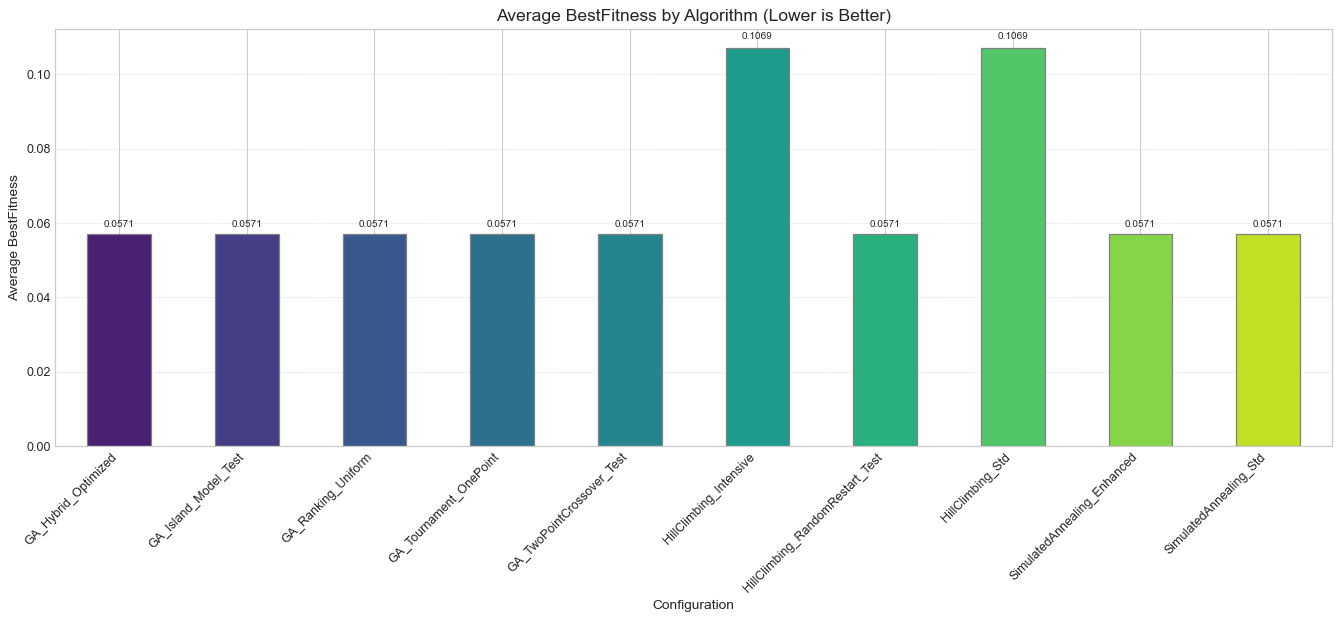

2025-05-26 02:05:17 - INFO - [MainProcess] - experiment_utils.plot_summary_statistics_bars:175 - 
📊 Statistics for: Iterations


,mean,std,min,max
Configuration,,,,
GA_Hybrid_Optimized,51.0,nan,51.0,51.0
GA_Island_Model_Test,101.0,nan,101.0,101.0
GA_Ranking_Uniform,51.0,nan,51.0,51.0
GA_Tournament_OnePoint,51.0,nan,51.0,51.0
GA_TwoPointCrossover_Test,51.0,nan,51.0,51.0
HillClimbing_Intensive,5.0,nan,5.0,5.0
HillClimbing_RandomRestart_Test,10.0,nan,10.0,10.0
HillClimbing_Std,5.0,nan,5.0,5.0
SimulatedAnnealing_Enhanced,19231.0,nan,19231.0,19231.0


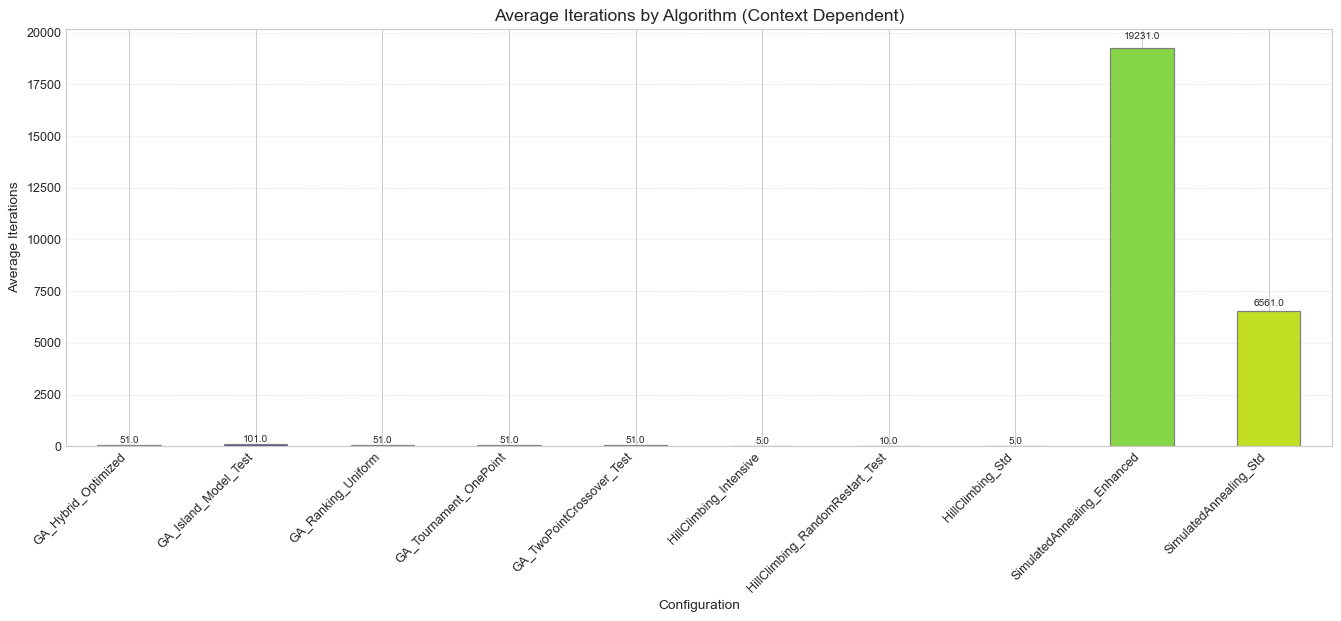

2025-05-26 02:05:18 - INFO - [MainProcess] - experiment_utils.plot_summary_statistics_bars:175 - 
📊 Statistics for: FunctionEvaluations


,mean,std,min,max
Configuration,,,,
GA_Hybrid_Optimized,65893.0,nan,65893.0,65893.0
GA_Island_Model_Test,92641.0,nan,92641.0,92641.0
GA_Ranking_Uniform,994295.0,nan,994295.0,994295.0
GA_Tournament_OnePoint,41907.0,nan,41907.0,41907.0
GA_TwoPointCrossover_Test,45978.0,nan,45978.0,45978.0
HillClimbing_Intensive,26511.0,nan,26511.0,26511.0
HillClimbing_RandomRestart_Test,70191.0,nan,70191.0,70191.0
HillClimbing_Std,13511.0,nan,13511.0,13511.0
SimulatedAnnealing_Enhanced,19232.0,nan,19232.0,19232.0


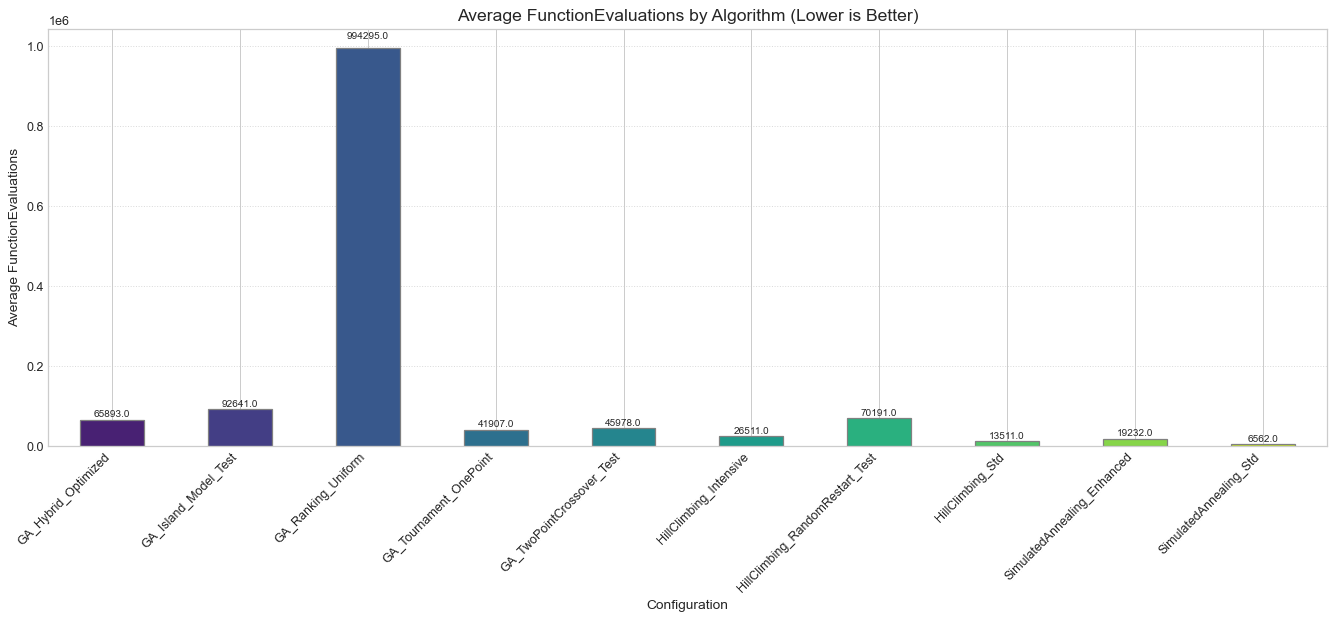

2025-05-26 02:05:18 - INFO - [MainProcess] - experiment_utils.plot_summary_statistics_bars:175 - 
📊 Statistics for: RuntimeSeconds


,mean,std,min,max
Configuration,,,,
GA_Hybrid_Optimized,116.4460,nan,116.4460,116.4460
GA_Island_Model_Test,1.9842,nan,1.9842,1.9842
GA_Ranking_Uniform,0.8839,nan,0.8839,0.8839
GA_Tournament_OnePoint,0.5298,nan,0.5298,0.5298
GA_TwoPointCrossover_Test,0.9092,nan,0.9092,0.9092
HillClimbing_Intensive,3.7171,nan,3.7171,3.7171
HillClimbing_RandomRestart_Test,9.0162,nan,9.0162,9.0162
HillClimbing_Std,1.7620,nan,1.7620,1.7620
SimulatedAnnealing_Enhanced,1.8868,nan,1.8868,1.8868


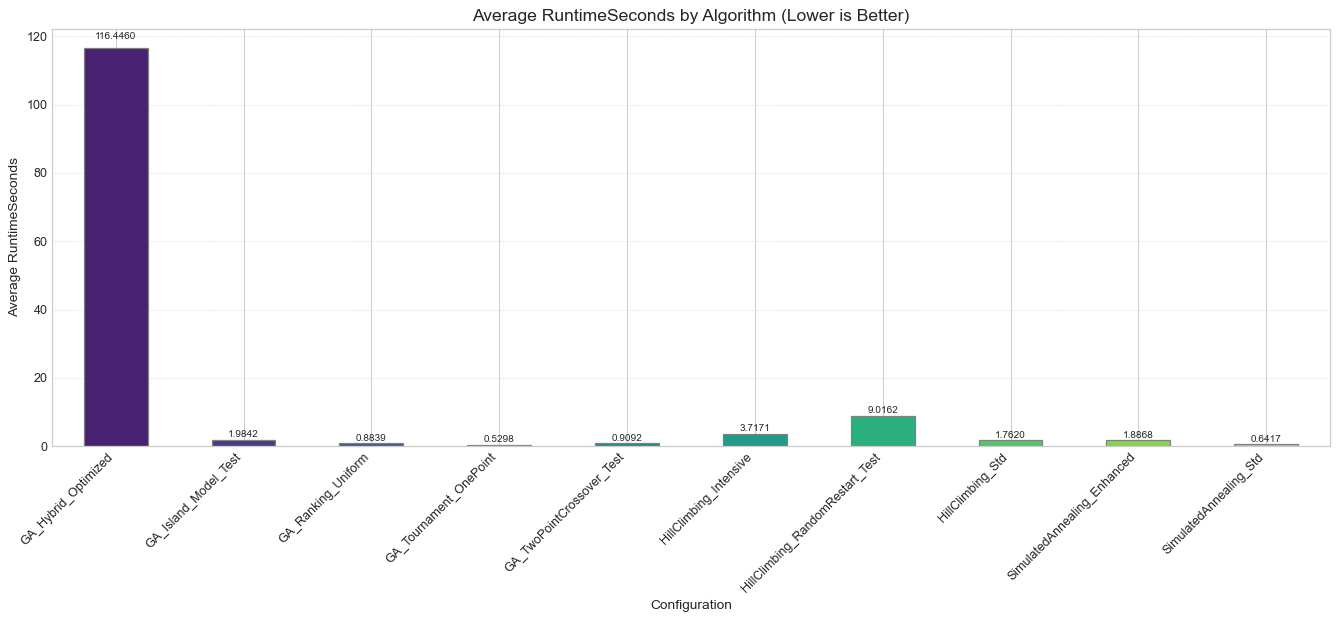

2025-05-26 02:05:19 - INFO - [MainProcess] - experiment_utils.plot_metric_distributions_boxplots:207 - 
--- Box Plots for Metric Distributions ---


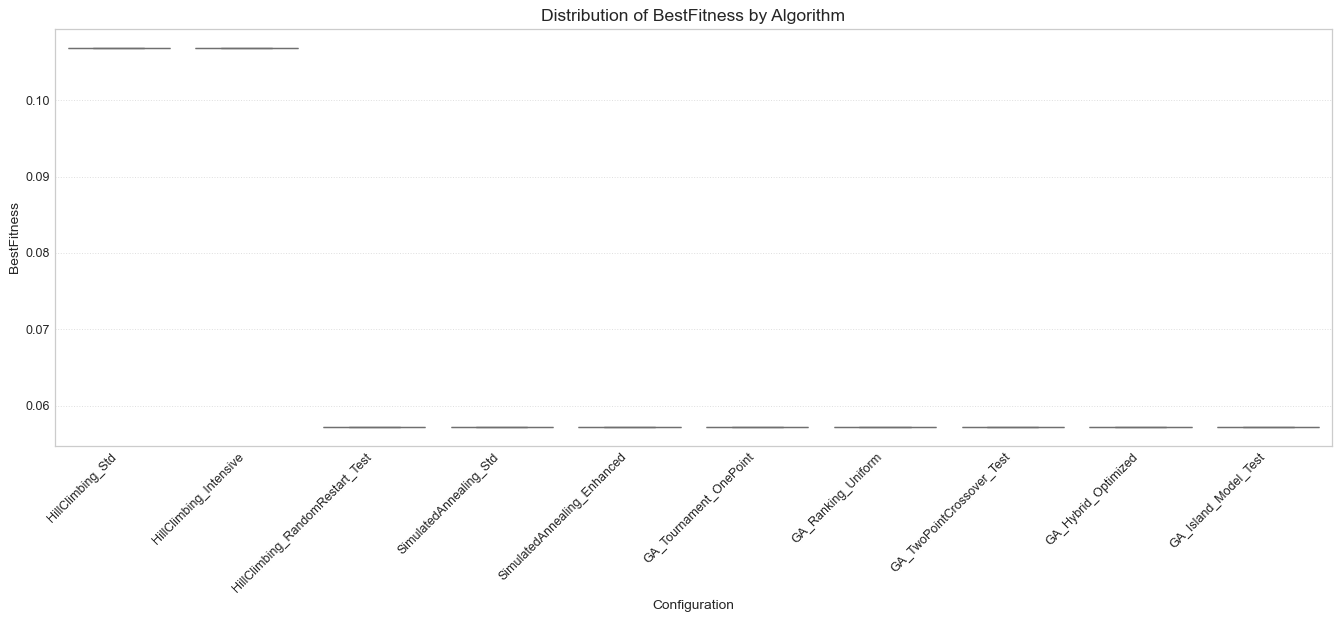

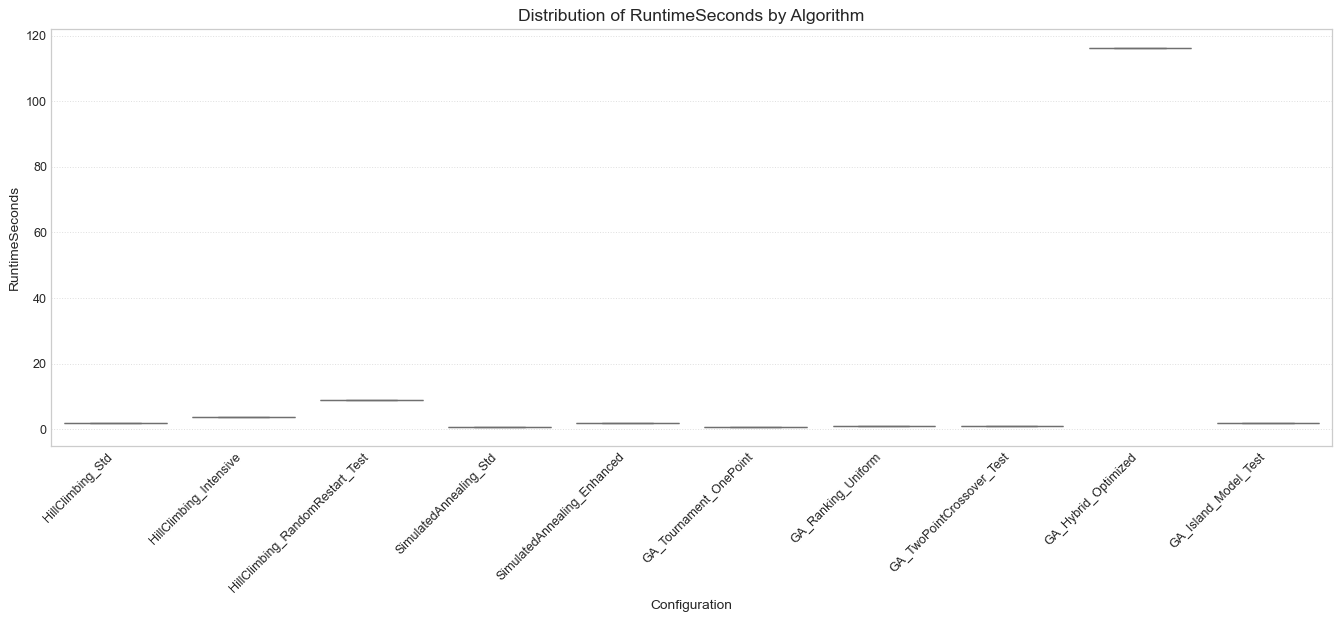

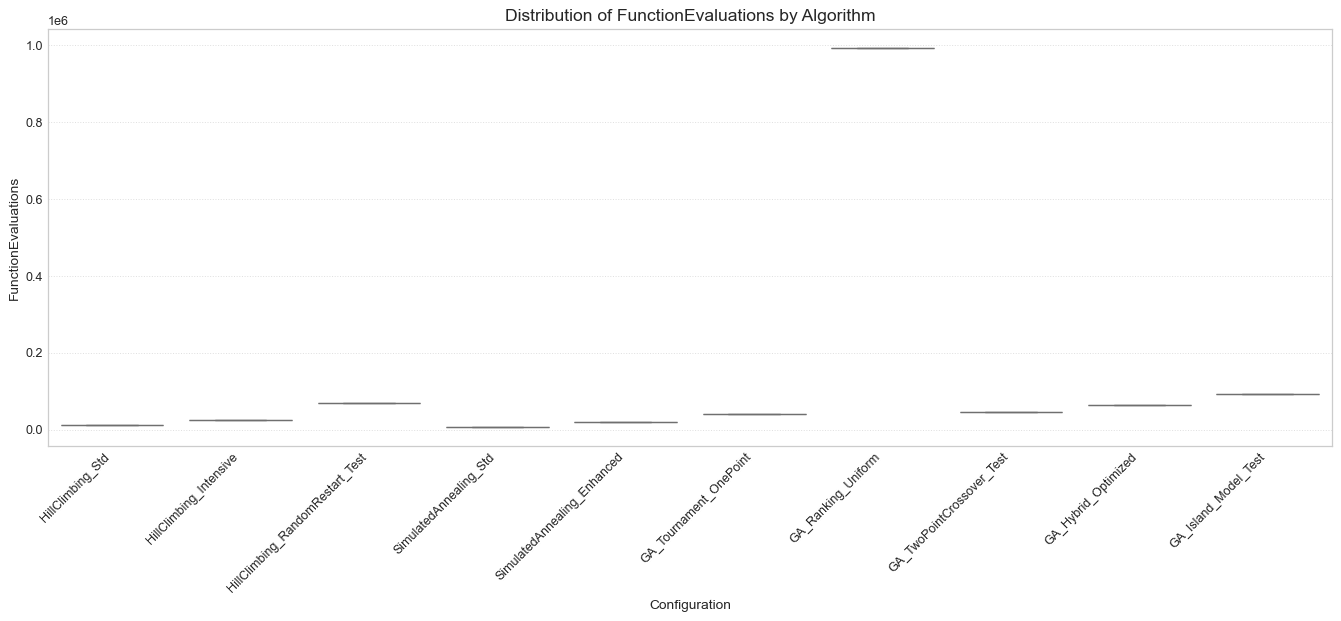

2025-05-26 02:05:22 - INFO - [MainProcess] - experiment_utils.plot_convergence_curves:227 - 
--- Convergence Plots ---


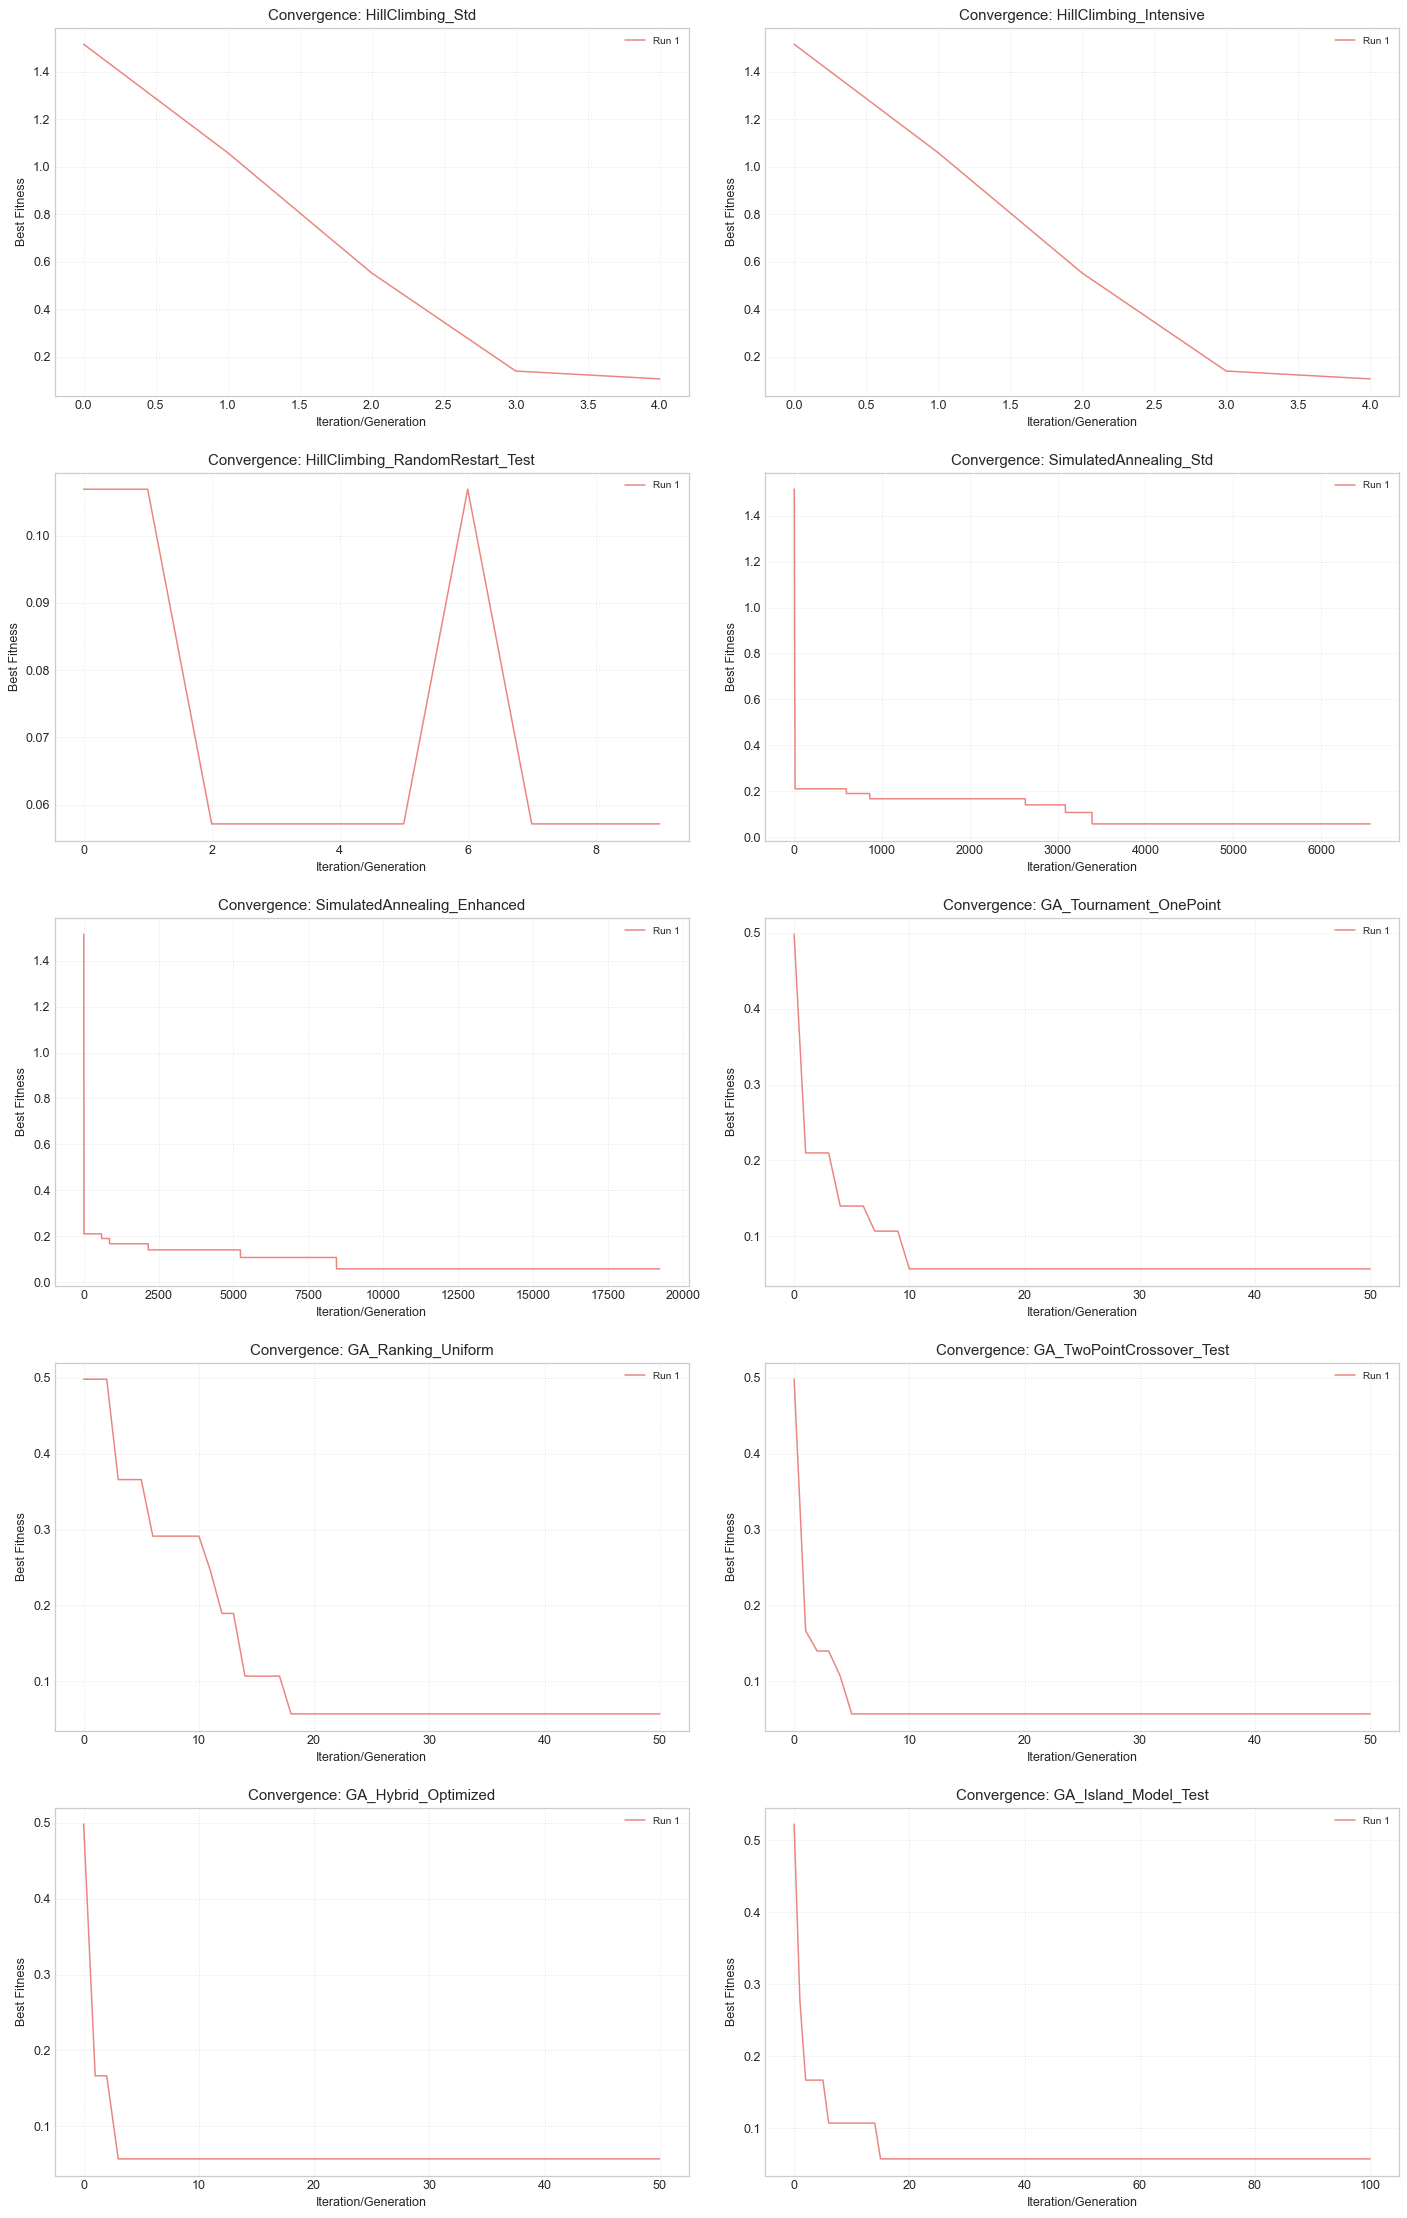

2025-05-26 02:05:25 - INFO - [MainProcess] - experiment_utils.rank_algorithms_custom:258 - 
--- Algorithm Performance Ranking ---
2025-05-26 02:05:25 - INFO - [MainProcess] - experiment_utils.rank_algorithms_custom:288 - 
Algorithm Ranking Table (Lower OverallRank is Better):


,OverallRank,FitnessRank,RuntimeRank,EvalsRank,ConsistencyRank,MeanBestFitness,StdBestFitness,MeanRuntime,MeanEvals,ConsistencyScore
Configuration,,,,,,,,,,
SimulatedAnnealing_Std,1.0,1.0,2.0,1.0,1.0,0.0571,0.0000,0.642,6562.0,1000000000.00
GA_Tournament_OnePoint,2.0,1.0,1.0,5.0,1.0,0.0571,0.0000,0.530,41907.0,1000000000.00
SimulatedAnnealing_Enhanced,3.0,1.0,6.0,3.0,1.0,0.0571,0.0000,1.887,19232.0,1000000000.00
GA_TwoPointCrossover_Test,4.0,1.0,4.0,6.0,1.0,0.0571,0.0000,0.909,45978.0,1000000000.00
GA_Ranking_Uniform,5.0,1.0,3.0,10.0,1.0,0.0571,0.0000,0.884,994295.0,1000000000.00
HillClimbing_Std,6.0,9.0,5.0,2.0,1.0,0.1069,0.0000,1.762,13511.0,1000000000.00
GA_Island_Model_Test,7.0,1.0,7.0,9.0,1.0,0.0571,0.0000,1.984,92641.0,1000000000.00
GA_Hybrid_Optimized,8.0,1.0,10.0,7.0,1.0,0.0571,0.0000,116.446,65893.0,1000000000.00
HillClimbing_RandomRestart_Test,8.0,1.0,9.0,8.0,1.0,0.0571,0.0000,9.016,70191.0,1000000000.00


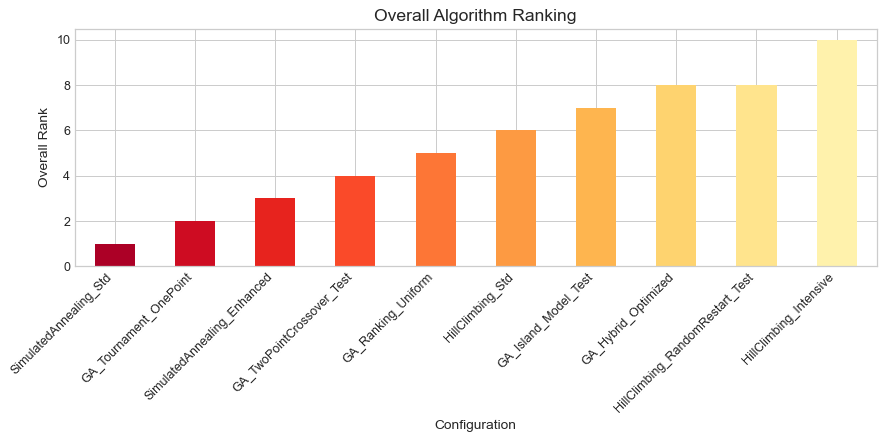

2025-05-26 02:05:26 - INFO - [MainProcess] - 2787798713.<module>:104 - 
--- Detailed Analysis of Overall Best Solution ---
2025-05-26 02:05:26 - INFO - [MainProcess] - experiment_utils.display_single_best_solution_details:344 - 
--- Detailed Analysis: Best Solution from 'HillClimbing_RandomRestart_Test', Run 1 (Fitness: 0.0571) ---
2025-05-26 02:05:26 - INFO - [MainProcess] - experiment_utils.display_single_best_solution_details:362 - Recreated Best Solution: Is Valid = True, Recalculated Fitness = 0.0571
2025-05-26 02:05:26 - INFO - [MainProcess] - experiment_utils.display_single_best_solution_details:372 - 
--- Detailed Team Breakdown for Overall Best Solution ---
2025-05-26 02:05:26 - INFO - [MainProcess] - category.update:224 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 02:05:26 - INFO - [MainProcess] - category.update:224 - U


Team 0:
  Players (7): ['Ryan Mitchell', 'Daniel Foster', 'Mason Reed', 'Connor Hayes', 'Austin Torres', 'Xavier Bryant', 'Landon Powell']
  Avg Skill: 86.43
  Total Salary: 685.00 (Budget Limit: 750.0)
  Actual Positions: {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2} (Required: {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2})

Team 1:
  Players (7): ['Alex Carter', 'Owen Parker', 'Caleb Fisher', 'Nathan Wright', 'Tyler Jenkins', 'Ashton Phillips', 'Zachary Nelson']
  Avg Skill: 86.43
  Total Salary: 667.00 (Budget Limit: 750.0)
  Actual Positions: {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2} (Required: {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2})

Team 2:
  Players (7): ['Chris Thompson', 'Logan Brooks', 'Dylan Morgan', 'Sebastian Perry', 'Adrian Collins', 'Bentley Rivera', 'Jaxon Griffin']
  Avg Skill: 86.29
  Total Salary: 695.00 (Budget Limit: 750.0)
  Actual Positions: {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2} (Required: {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2})

Team 3:
  Players (7): ['Jordan Smith', 'L

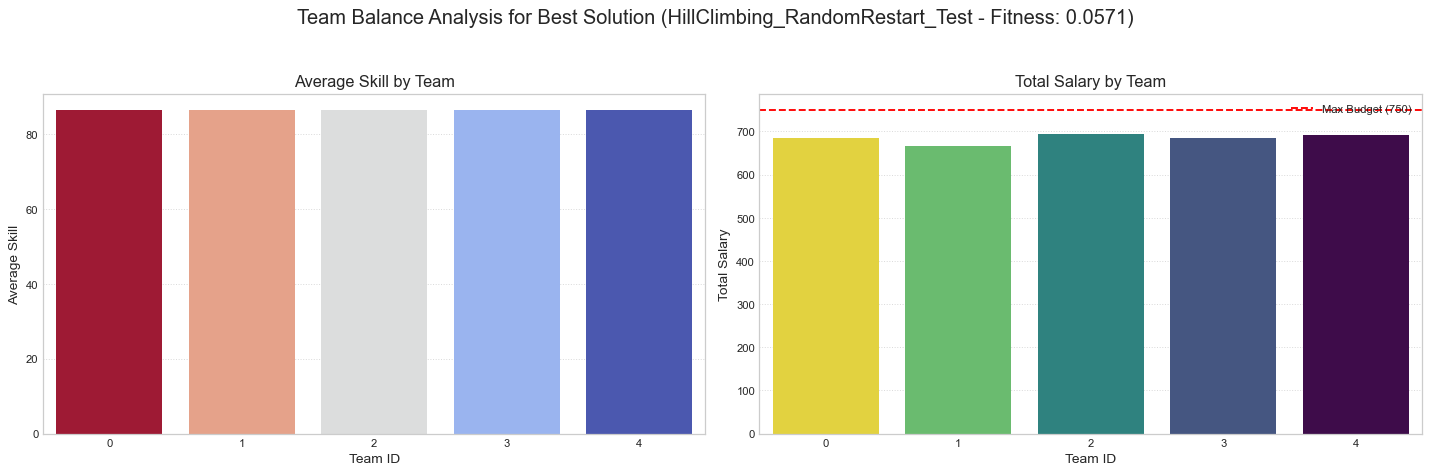

2025-05-26 02:05:26 - INFO - [MainProcess] - category.update:224 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 02:05:26 - INFO - [MainProcess] - category.update:224 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


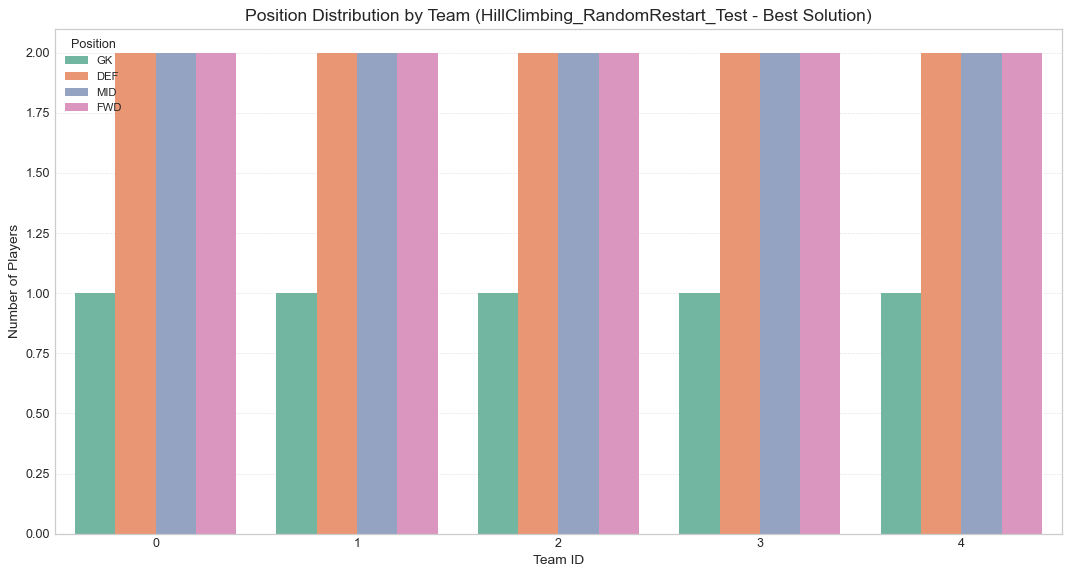

2025-05-26 02:05:26 - INFO - [MainProcess] - experiment_utils.display_single_best_solution_details:496 - --- End of Detailed Analysis for Overall Best Solution (HillClimbing_RandomRestart_Test) ---
2025-05-26 02:05:26 - INFO - [MainProcess] - 2787798713.<module>:139 - Total script execution duration: 148.08 seconds (2.47 minutes).
2025-05-26 02:05:26 - INFO - [MainProcess] - 2787798713.<module>:140 - ======================================================================
2025-05-26 02:05:26 - INFO - [MainProcess] - 2787798713.<module>:141 - =========== 🏆 Sports League Optimization Script Execution End 🏆 ===========
2025-05-26 02:05:26 - INFO - [MainProcess] - 2787798713.<module>:142 - ======================================================================


In [ ]:
if __name__ == "__main__":
    # freeze_support() is necessary for multiprocessing in packaged executables (e.g., PyInstaller)
    # and sometimes helpful on Windows. It should be called right at the start of the main block.
    mp.freeze_support() 
    logger.info("======================================================================")
    logger.info("========== 🏆 Sports League Optimization Script Execution Started 🏆 ==========")
    logger.info("======================================================================")

    script_overall_start_time = time.time()
    # These global variables should have been defined in earlier cells/sections of your script:
    # problem_definition_global, players_data, EXPERIMENT_CONFIG, all_configs, solution_module_ref
    logger.info(f"Global Problem Definition: {problem_definition_global}")
    logger.info(f"Player Data: {len(players_data)} players loaded.")
    logger.info(f"Experiment Execution Config: {EXPERIMENT_CONFIG}")

    # --- Run the Experimental Suite ---
    # This function call will execute all defined algorithm configurations for the specified number of runs.
    final_results_df, final_history_map, final_best_solutions_data_map = run_experimental_suite(
        configurations_dict=all_configs,    # Defined in Section 2.1
        master_players_list_all=players_data,      # Loaded in Section 1.2
        master_problem_definition=problem_definition_global, # Defined in Section 1.1
        num_runs=EXPERIMENT_CONFIG['num_runs'], 
        use_parallel=EXPERIMENT_CONFIG['parallel'], 
        num_procs=EXPERIMENT_CONFIG['num_processes'] 
    )
    logger.info("Experimental suite execution completed.")
    
    # --- Save Main Results to CSV File ---
    if EXPERIMENT_CONFIG['save_results_csv'] and not final_results_df.empty:
        try:
            final_results_df.to_csv(EXPERIMENT_CONFIG['results_csv_file'], index=False)
            logger.info(f"Results successfully saved to CSV: {EXPERIMENT_CONFIG['results_csv_file']}")
        except Exception as e_csv_save: 
            logger.error(f"Error saving results to CSV file '{EXPERIMENT_CONFIG['results_csv_file']}': {e_csv_save}")
    elif not final_results_df.empty: 
        logger.info("CSV saving is disabled in EXPERIMENT_CONFIG. Results not saved to disk.")
    else: 
        logger.warning("No results generated (results DataFrame is empty). Nothing to save to CSV.")


    # --- Save Best Solution Objects (Pickled, Optional) ---
    if EXPERIMENT_CONFIG['save_best_solution_objects'] and final_best_solutions_data_map:
        logger.info("Saving best solution objects (pickled) for each configuration...")
        for config_name_for_pickle, best_solution_data_item in final_best_solutions_data_map.items():
            if best_solution_data_item and best_solution_data_item.get('solution_data'):
                try:
                    solution_object_to_pickle = recreate_solution_from_data( # from experiment_utils
                        stored_solution_data=best_solution_data_item['solution_data'],
                        master_players_list_for_recreation=players_data,
                        problem_definition_for_recreation=problem_definition_global,
                        solution_classes_module=solution_module_ref # Pass the imported solution module
                    )
                    if solution_object_to_pickle:
                        safe_filename_config_part = "".join(
                            c if c.isalnum() or c in ['-', '_'] else "_" for c in config_name_for_pickle
                        )
                        pickle_filename = EXPERIMENT_CONFIG['pickle_file_template'].format(
                            config_name_safe=safe_filename_config_part
                        )
                        with open(pickle_filename, 'wb') as f_pickle_output_stream:
                            pickle.dump(solution_object_to_pickle, f_pickle_output_stream)
                        logger.info(f"Successfully saved best solution object for '{config_name_for_pickle}' to '{pickle_filename}'")
                except Exception as e_pickle_obj_save:
                    logger.error(f"Error pickling solution object for configuration '{config_name_for_pickle}': {e_pickle_obj_save}")
            else:
                 logger.warning(f"No solution data available to pickle for configuration: {config_name_for_pickle}")
    elif EXPERIMENT_CONFIG['save_best_solution_objects']:
        logger.info("Pickling of best solution objects is enabled, but no best solutions were found/stored.")


    # --- Result Analysis and Plotting (Using functions from experiment_utils.py) ---
    if not final_results_df.empty: 
        logger.info("\n" + "="*30 + " 📊 RESULTS ANALYSIS 📊 " + "="*30)

        # Ensure analysis functions are imported from experiment_utils.py at the top of this script
        # from experiment_utils import (
        #     plot_summary_statistics_bars,
        #     plot_metric_distributions_boxplots,
        #     plot_convergence_curves,
        #     rank_algorithms_custom,
        #     display_single_best_solution_details
        # )
        # And ensure solution_module_ref is defined: import solution as solution_module_ref

        # Call the plotting and analysis functions (now imported from experiment_utils.py)
        plot_summary_statistics_bars(final_results_df)
        plot_metric_distributions_boxplots(final_results_df)
        plot_convergence_curves(final_history_map)
        
        # Filter data for ranking (excluding error rows and non-finite fitness)
        valid_results_for_ranking = final_results_df[
            final_results_df['BestFitness'].notna() & 
            np.isfinite(final_results_df['BestFitness']) &
            (~final_results_df['AlgorithmName'].str.contains("ERROR", case=False, na=False)) # Exclude error rows
        ]
        if not valid_results_for_ranking.empty:
            # The rank_algorithms_custom function (from experiment_utils.py)
            # handles its own printing/displaying of the rank table and plot.
            algorithm_ranking_df = rank_algorithms_custom(valid_results_for_ranking) 
        else:
            logger.info("No valid results to perform algorithm ranking.")

        # --- Detailed Analysis of the Single Best Solution Found ---
        logger.info("\n--- Detailed Analysis of Overall Best Solution ---")
        overall_best_config_name = None
        overall_best_run_number = None
        overall_best_fitness_val = float('inf')
        overall_best_solution_storage_data = None

        if final_best_solutions_data_map: # Check if the map has any entries
            for config_name_iter, best_data_item in final_best_solutions_data_map.items():
                if best_data_item and 'fitness' in best_data_item and \
                   np.isfinite(best_data_item['fitness']) and \
                   best_data_item['fitness'] < overall_best_fitness_val:
                    overall_best_fitness_val = best_data_item['fitness']
                    overall_best_solution_storage_data = best_data_item['solution_data']
                    overall_best_config_name = config_name_iter
                    overall_best_run_number = best_data_item['run_number']
        
        if overall_best_solution_storage_data and overall_best_config_name is not None:
            display_single_best_solution_details(
                best_sol_data=overall_best_solution_storage_data,       # Corrected
                config_name=overall_best_config_name,                   # Corrected
                fitness=overall_best_fitness_val,                       # Corrected
                run_num=overall_best_run_number,                        # Corrected
                players_list=players_data,                              # Corrected
                problem_def=problem_definition_global,                  # Corrected
                sol_module=solution_module_ref                          # Corrected
            )
        else:
            logger.info("No single overall best solution found or recorded for detailed analysis.")

    else: # This else corresponds to: if not final_results_df.empty:
        logger.warning("No results were generated from the experimental suite. "
                       "Analysis and plotting will be skipped. Please check logs for errors during execution.")

    script_overall_end_time = time.time()
    total_duration_seconds = script_overall_end_time - script_overall_start_time
    logger.info(f"Total script execution duration: {total_duration_seconds:.2f} seconds ({total_duration_seconds/60:.2f} minutes).")
    logger.info("======================================================================")
    logger.info("=========== 🏆 Sports League Optimization Script Execution End 🏆 ===========")
    logger.info("======================================================================")